In [1]:
import os
import re

from collections import defaultdict

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
METRIC_LITERA = 'BLEU4'

In [59]:
SCORE_DIR = 'scores_regless'
MODEL_DIR = 'mtransformer/de-en/model5'

IN_FILENAME = 'gen.out.in'
REF_FILENAME = 'gen.out.ref'

SYS_FILENAME = 'gen.out.sys'
SCORE_FILENAME = 'score.out'

RAW_FILENAME = 'gen.out'
IDXS_FILENAME = 'idxs.out'

scores_path = os.path.join(MODEL_DIR, SCORE_DIR)

In [60]:
beam2in = defaultdict(list)
beam2ref = defaultdict(list)

beam2sys = defaultdict(list)
beam2score = defaultdict(list)

beam2bleu = defaultdict(list)
beam2sid = defaultdict(list)

beam2total = {}
beam2idxs = {}

for beam_folder in os.listdir(scores_path):
    beam_width = int(beam_folder[1:])
    beam_path = os.path.join(scores_path, beam_folder)
    
    with open(os.path.join(beam_path, IN_FILENAME)) as input_stream:
        beam2in[beam_width] = input_stream.readlines()
        
    with open(os.path.join(beam_path, REF_FILENAME)) as input_stream:
        beam2ref[beam_width] = input_stream.readlines()
        
    with open(os.path.join(beam_path, SYS_FILENAME)) as input_stream:
        beam2sys[beam_width] = input_stream.readlines()
        
    with open(os.path.join(beam_path, SCORE_FILENAME)) as input_stream:
        beam2score[beam_width] = input_stream.readlines()
        
    with open(os.path.join(beam_path, IDXS_FILENAME)) as input_stream:
        beam2idxs[beam_width] = list(map(int, input_stream.readlines()))
        
    with open(os.path.join(beam_path, RAW_FILENAME)) as input_stream:
        beam2total[beam_width] = float(re.split(
            ',|\s',
            input_stream.readlines()[-1]
        )[7])

In [61]:
for beam_width in beam2score:
    beam2score[beam_width] = beam2score[beam_width][1:]
    
    beam2bleu[beam_width] = [float(re.split(',|\s', x)[3]) for x in beam2score[beam_width]]
    beam2sid[beam_width] = [int(re.split(',|\s', x)[0]) for x in beam2score[beam_width]]

In [62]:
beam2pack = defaultdict(tuple)

for beam in beam2in:
    beam2in[beam] = np.array(beam2in[beam])
    beam2ref[beam] = np.array(beam2ref[beam])
    beam2sys[beam] = np.array(beam2sys[beam])
    beam2bleu[beam] = np.array(beam2bleu[beam])
    beam2idxs[beam] = np.array(beam2idxs[beam])
    
    idxs_s = np.argsort(beam2idxs[beam])
    
    
    beam2pack[beam] = (
        beam2in[beam][idxs_s],
        beam2ref[beam][idxs_s],
        beam2sys[beam][idxs_s],
        beam2bleu[beam][idxs_s],
    )

In [63]:
beam_widths, scores = np.array(list(beam2total.keys())), np.array(list(beam2total.values()))

In [64]:
idx_s = np.argsort(beam_widths)

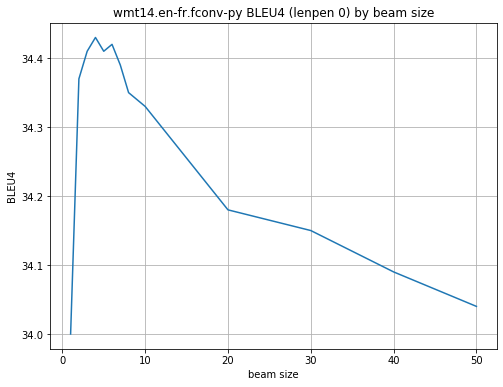

In [65]:
plt.figure(figsize=(8, 6))

plt.plot(beam_widths[idx_s], scores[idx_s])
plt.xlabel('beam size')
plt.ylabel('BLEU4')
plt.title('wmt14.en-fr.fconv-py BLEU4 (lenpen 0) by beam size')
plt.grid()

In [18]:
def get_worst_predictions(inputs, targets, preds, bleu_scores, k):
    idxs_s = np.argsort(bleu_scores)
    out_idxs = idxs_s[:k]
    
    return inputs[out_idxs], targets[out_idxs], preds[out_idxs], bleu_scores[out_idxs]

In [19]:
TOP_K_VALUE = 100

for beam in sorted(beam2pack.keys()):
    print('$$$', beam)
    inputs, targets, preds, bleu_scores = get_worst_predictions(*beam2pack[beam], TOP_K_VALUE)
    
    for input_sent, target, pred, bleu_score in zip(inputs, targets, preds, bleu_scores):
        print()
        print('\t', 'INPUT:', input_sent)
        print('\t', 'TARGET:', target)
        print('\t', 'PREDICTION:', pred)
        print('\t', 'BLEU:', bleu_score)

$$$ 1

	 INPUT: Drink liters of oil

	 TARGET: Пить масло <<unk>> рами

	 PREDICTION: Дырки от нефти

	 BLEU: 0.0

	 INPUT: China plea paper &apos; to be overhauled&apos;

	 TARGET: Опубликовавшая призыв <<unk>> газета <<unk>> подлежит реорганизации <<unk>>

	 PREDICTION: Китай просит &quot; перестроить &quot; его

	 BLEU: 0.0

	 INPUT: Australian woman appeals Thai jail time

	 TARGET: Австралийская женщина подает <<unk>> лляцию против тюремного срока в Таиланде

	 PREDICTION: Австралийка обжаловала тайский тюремный срок

	 BLEU: 0.0

	 INPUT: Obama &apos;s Health Care Walk Back

	 TARGET: Обама отказывается от своих слов о <<unk>>

	 PREDICTION: Оздоровительная прогулка Обамы

	 BLEU: 0.0

	 INPUT: There was general <unk> with the Single Market , with businesses saying that the costs of Brussels regulation now outweighed the benefits of being part of Europe &apos;s trading area - even 40 per cent of large businesses , traditionally the most pro @-@ European of companies , agreed .

	

	 PREDICTION: Блондинка Пэм прославилась благодаря своей роли в сексуальном телешоу Baywatch .

	 BLEU: 8.41

	 INPUT: NSA revelations boost corporate <unk> ia about state surveillance

	 TARGET: Признания Агентства национальной безопасности <<unk>> <<unk>> йю <<unk>> в отношении государственной слежки

	 PREDICTION: Откровения NSA усиливают корпоративное беспокойство о государственной слежке

	 BLEU: 8.42

	 INPUT: She was spotted three days later by a dog walker trapped in the quarry

	 TARGET: Спустя три дня ее , <<unk>> вшую в <<unk>> е , заметил человек , выгуливавший собаку

	 PREDICTION: Три дня спустя ее обнаружил пес , застрявший в карьере

	 BLEU: 8.43

	 INPUT: The city appealed her findings and her remedial orders , including a decision to assign a monitor to help the police department changes its policy and training program associated with it .

	 TARGET: Город подал <<unk>> лляционную жалобу на ее решение и постановления о корректирующих мерах , включая предписание назнач

	 INPUT: Mr Usher &apos;s instant message group included bankers at Barclays and Citigroup , people close to the situation said .

	 TARGET: Группа контактов мгновенных сообщений г @-@ на Ашера включала <<unk>> из Bar<<unk>> ys и <<unk>> <<unk>> , по словам осведомленных лиц .

	 PREDICTION: В группу мгновенных сообщений господина Ашера входили банкиры из Barclays и Citigroup , рассказали люди , близкие к ситуации .

	 BLEU: 9.1

	 INPUT: So , a non @-@ story , then .

	 TARGET: Так что это не <<unk>> ющая внимания история .

	 PREDICTION: Итак , небылица .

	 BLEU: 9.15

	 INPUT: Two detectives trailed the suspect and spotted him arriving at Ditta &apos;s house in and was seen to place the drugs which had a purity of 60 per cent under the lawyer &apos;s bins in a black golf glove .

	 TARGET: Два дете<<unk>> а <<unk>> дили за подозреваемым и обнаружили , как он подошел к дому Д<<unk>> та в Блэкберне и поме<<unk>> наркотики 60 @-@ процентной <<unk>> ты в черной перчатке для гольфа под 


	 INPUT: China plea paper &apos; to be overhauled&apos;

	 TARGET: Опубликовавшая призыв <<unk>> газета <<unk>> подлежит реорганизации <<unk>>

	 PREDICTION: Китай просит &quot; провести капитальный ремонт &quot;

	 BLEU: 0.0

	 INPUT: Obama &apos;s Health Care Walk Back

	 TARGET: Обама отказывается от своих слов о <<unk>>

	 PREDICTION: Здоровье Обамы возвращается

	 BLEU: 0.0

	 INPUT: Australian woman appeals Thai jail time

	 TARGET: Австралийская женщина подает <<unk>> лляцию против тюремного срока в Таиланде

	 PREDICTION: Австралийка обжаловала тайский тюремный срок

	 BLEU: 0.0

	 INPUT: Jet makers feud over seat width with big orders at stake

	 TARGET: <<unk>> <<unk>> реактивных самолетов враждуют по поводу ширины сиденья , когда на <<unk>> большие заказы

	 PREDICTION: Производители джет ссорятся из @-@ за расширения сидений с крупными заказами

	 BLEU: 0.0

	 INPUT: Sony anticipates a lower annual profit

	 TARGET: S<<unk>> <<unk>> ет на более <<unk>> годовую прибыль

	 P

	 PREDICTION: Оба трейдера станут первыми сотрудниками RBS , отстраненными от работы в связи со скандалом с манипуляциями с межбанковским кредитованием .

	 BLEU: 8.31

	 INPUT: Mr Ditta is accused of abusing his position as a criminal solicitor , having become too involved with specific clients .

	 TARGET: Г @-@ н Д<<unk>> та обвиняется в злоупотреблении своим положением адвоката по <<unk>> вным делам , поскольку он вступил в слишком близкие отношения с <<unk>> клиентами .

	 PREDICTION: Дитта обвиняют в том , что он злоупотреблял своим положением преступного солиситора , слишком много общаясь с конкретными клиентами .

	 BLEU: 8.35

	 INPUT: But after the hearing Supt Lee Halstead from Lancashire Police said : &quot; Mr Ditta turned from criminal solicitor to a criminal himself the moment he started obtaining drugs from organised criminals . &quot;

	 TARGET: Но после заседания старший офицер Ли Холстед из полиции Ланкашира заявил : <<unk>> Г @-@ н Д<<unk>> та <<unk>> из адвоката по

	 INPUT: There was general <unk> with the Single Market , with businesses saying that the costs of Brussels regulation now outweighed the benefits of being part of Europe &apos;s trading area - even 40 per cent of large businesses , traditionally the most pro @-@ European of companies , agreed .

	 TARGET: Присутствовало общее недовольство единым <<unk>> , причем представители бизнеса заявляли , что издержки от регулирования из Брюсселя сейчас <<unk>> вают преимущества от нахождения в торговой зоне Европы , <<unk>> согласились с этим даже 40 процентов крупных предприятий , традиционно наиболее проевропейски <<unk>> из всех компаний .

	 PREDICTION: С этим мнением согласились даже 40 % крупных компаний , традиционно наиболее проевропейских .

	 BLEU: 2.3

	 INPUT: Kids may say , &quot; It feels like something is poking my tongue , &quot; &quot; My tongue feels like there is hair on it , &quot; or &quot; My tongue is tingling . &quot;

	 TARGET: Дети могут говорить : <<unk>> такое ощущен

In [20]:
def get_beam_diff(a_pack, b_pack, k):
    a_inputs, a_targets, a_preds, a_scores = a_pack
    b_inputs, b_targets, b_preds, b_scores = b_pack
    
    diffs = np.abs(a_scores - b_scores)
    idx_s = np.argsort(diffs)
    top_idxs = idx_s[-k:]
    
    return (
            a_inputs[top_idxs],
            a_targets[top_idxs],
            a_preds[top_idxs],
            b_preds[top_idxs],
            a_scores[top_idxs],
            b_scores[top_idxs]
    )

In [21]:
TOP_K_VALUE = 5

beam_arr = np.sort(list(beam2pack.keys()))
for i, b1 in enumerate(beam_arr):
    for j, b2 in enumerate(beam_arr):
        if j <= i:
            continue
            
        inps, targets, a_preds, b_preds, a_scores, b_scores = get_beam_diff(beam2pack[b1], beam2pack[b2], TOP_K_VALUE)
        
        print('$$$', b1, b2)
        for input_sent, target, a_pred, b_pred, a_score, b_score in zip(
            inps,
            targets,
            a_preds,
            b_preds,
            a_scores,
            b_scores
        ):
                print()
                print('\t', 'INPUT:', input_sent)
                print('\t', 'TARGET:', target)
                print('\t', 'FIRST PREDICTION:', a_pred)
                print('\t', 'SECOND PREDICTION:', b_pred)
                print('\t', 'FIRST BLEU:', a_score)
                print('\t', 'SECOND BLEU', b_score)

$$$ 1 2

	 INPUT: A <unk> Z commuter bus flipped over in the Rubtsovsky district of Al<unk> Territory .

	 TARGET: В Рубцовском районе Алтайского края перевернулся рейсовый автобус ПАЗ .

	 FIRST PREDICTION: В Рубцовском районе Алтайского края перевернулся рейсовый автобус .

	 SECOND PREDICTION: В Рубцовском районе Алтая перевернулся рейсовый автобус .

	 FIRST BLEU: 80.86
	 SECOND BLEU 34.62

	 INPUT: And the punishment came .

	 TARGET: И наказание пришло .

	 FIRST PREDICTION: И наказание наступило .

	 SECOND PREDICTION: И наказание пришло .

	 FIRST BLEU: 50.0
	 SECOND BLEU 100.0

	 INPUT: They may interrogate Snowden in Russia

	 TARGET: Сноудена могут допросить в России

	 FIRST PREDICTION: В России могут допросить Сноудена

	 SECOND PREDICTION: Сноудена могут допросить в России

	 FIRST BLEU: 40.41
	 SECOND BLEU 100.0

	 INPUT: The stewards are responsible for this .

	 TARGET: За это отвечают стюарды .

	 FIRST PREDICTION: Ответственность за это несут стюарды .

	 SECOND PRED


	 TARGET: Центр заявил , что в четверг были жертвы с обеих сторон , но не привел конкретных данных .

	 FIRST PREDICTION: В четверг , по данным &quot; Обозревателя &quot; , с обеих сторон были жертвы , но никаких подробностей нет .

	 SECOND PREDICTION: Обсерватория сообщила , что в четверг были жертвы с обеих сторон , но никаких подробностей нет .

	 FIRST BLEU: 16.44
	 SECOND BLEU 60.66

	 INPUT: Malaysia topped the list at 80 per cent of GDP , up from 60 per cent in 2008 .

	 TARGET: Малайзия возглавила этот список с 80 % от ВВП по сравнению с 60 % в 2008 году .

	 FIRST PREDICTION: Малайзия возглавила список с показателем в 80 процентов ВВП , что выше 60 процентов в 2008 году .

	 SECOND PREDICTION: Малайзия возглавила список с 80 % ВВП по сравнению с 60 % в 2008 году .

	 FIRST BLEU: 25.89
	 SECOND BLEU 70.72

	 INPUT: Furthermore , the damage to the Russian Federation at issue does not exist .

	 TARGET: Более того , нет никакого ущерба Российской Федерации , о котором идет речь

$$$ 5 10

	 INPUT: Moore added that if he uncovers sufficient evidence to warrant a criminal or civil rights investigation into the death of Johnson he will ask the FBI to conduct it .

	 TARGET: Мур добавил , что если он обнаружит достаточно улик , чтобы потребовать уголовного или гражданского расследования смерти Джонсона , он попросит ФБР провести его .

	 FIRST PREDICTION: Мур добавил , что если ему удастся собрать достаточно доказательств , чтобы начать уголовное или гражданское расследование смерти Джонсона , он попросит ФБР провести его .

	 SECOND PREDICTION: Мур добавил , что если он найдет достаточно доказательств , чтобы потребовать уголовного или гражданского расследования смерти Джонсона , он попросит ФБР провести его .

	 FIRST BLEU: 49.8
	 SECOND BLEU 82.0

	 INPUT: But children nonetheless must be <unk> adequately .

	 TARGET: А дети все же должны питаться полноценно .

	 FIRST PREDICTION: Но дети все же должны быть адекватными .

	 SECOND PREDICTION: Но дети , тем не м

$$$ 9 20

	 INPUT: But children nonetheless must be <unk> adequately .

	 TARGET: А дети все же должны питаться полноценно .

	 FIRST PREDICTION: Но дети все же должны быть адекватными .

	 SECOND PREDICTION: Но дети , тем не менее , должны быть адекватными .

	 FIRST BLEU: 45.97
	 SECOND BLEU 12.88

	 INPUT: &quot; But this move could make some foreign investors reticent to buy property in London or current owners reluctant to sell , &quot; he added .

	 TARGET: <<unk>> Но этот шаг может привести к тому , что некоторые иностранные инвесторы будут <<unk>> покупать недвижимость в Лондоне или нынешние ее владельцы не <<unk>> ее продавать <<unk>> , <<unk>> добавил он .

	 FIRST PREDICTION: &quot; Но этот шаг может привести к тому , что некоторые иностранные инвесторы будут неохотно покупать недвижимость в Лондоне или нынешние владельцы не захотят ее продавать &quot; , - добавил он .

	 SECOND PREDICTION: &quot; Но этот шаг может вызвать нежелание некоторых иностранных инвесторов покупать 